# KMeans — Spherical clusters and centroid evolution
This notebook demonstrates KMeans on a blob dataset with injected outliers/missing values, preprocessing, fitting, evaluation, and an evolution diagram showing centroid movements over iterations.

In [6]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

sns.set(style="whitegrid")

In [7]:
# Create blob dataset with outliers and missing values
rng = np.random.RandomState(42)
X, y = make_blobs(n_samples=800, centers=4, cluster_std=0.6, random_state=42)
# outliers 5%
n_out = int(0.05 * X.shape[0])
out_idx = rng.choice(X.shape[0], n_out, replace=False)
X[out_idx] += rng.normal(0, 8.0, size=(n_out, X.shape[1]))
# missing values ~1%
n_nan = max(1, int(0.01 * X.size))
rows = rng.randint(0, X.shape[0], n_nan)
cols = rng.randint(0, X.shape[1], n_nan)
X[rows, cols] = np.nan

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Shapes:", X_train.shape, X_test.shape)
print("NaNs (train/test):", np.isnan(X_train).sum(), np.isnan(X_test).sum())

Shapes: (560, 2) (240, 2)
NaNs (train/test): 9 7


In [8]:
# Preprocess: impute then RobustScaler
imputer = SimpleImputer(strategy='mean')
Xtr_imp = imputer.fit_transform(X_train)
Xte_imp = imputer.transform(X_test)

scaler = RobustScaler()
Xtr = scaler.fit_transform(Xtr_imp)
Xte = scaler.transform(Xte_imp)

In [9]:
# Fit KMeans and evaluate
k = 4
km = KMeans(n_clusters=k, random_state=42)
km.fit(Xtr)
labels_tr = km.predict(Xtr)
labels_te = km.predict(Xte)

metrics = {
    'ARI_train': adjusted_rand_score(y_train, labels_tr),
    'NMI_train': normalized_mutual_info_score(y_train, labels_tr),
    'Silhouette_train': silhouette_score(Xtr, labels_tr) if len(set(labels_tr))>1 else np.nan,
    'ARI_test': adjusted_rand_score(y_test, labels_te),
    'NMI_test': normalized_mutual_info_score(y_test, labels_te),
    'Silhouette_test': silhouette_score(Xte, labels_te) if len(set(labels_te))>1 else np.nan,
}
# avoid shadowing the cluster-count variable `k` by using different loop variable names
for name, val in metrics.items():
    print(f"{name}: {val}")

ARI_train: 0.9296899146789914
NMI_train: 0.900378751886541
Silhouette_train: 0.8307286373186603
ARI_test: 0.8525493921315382
NMI_test: 0.82647047732375
Silhouette_test: 0.8126381284997419


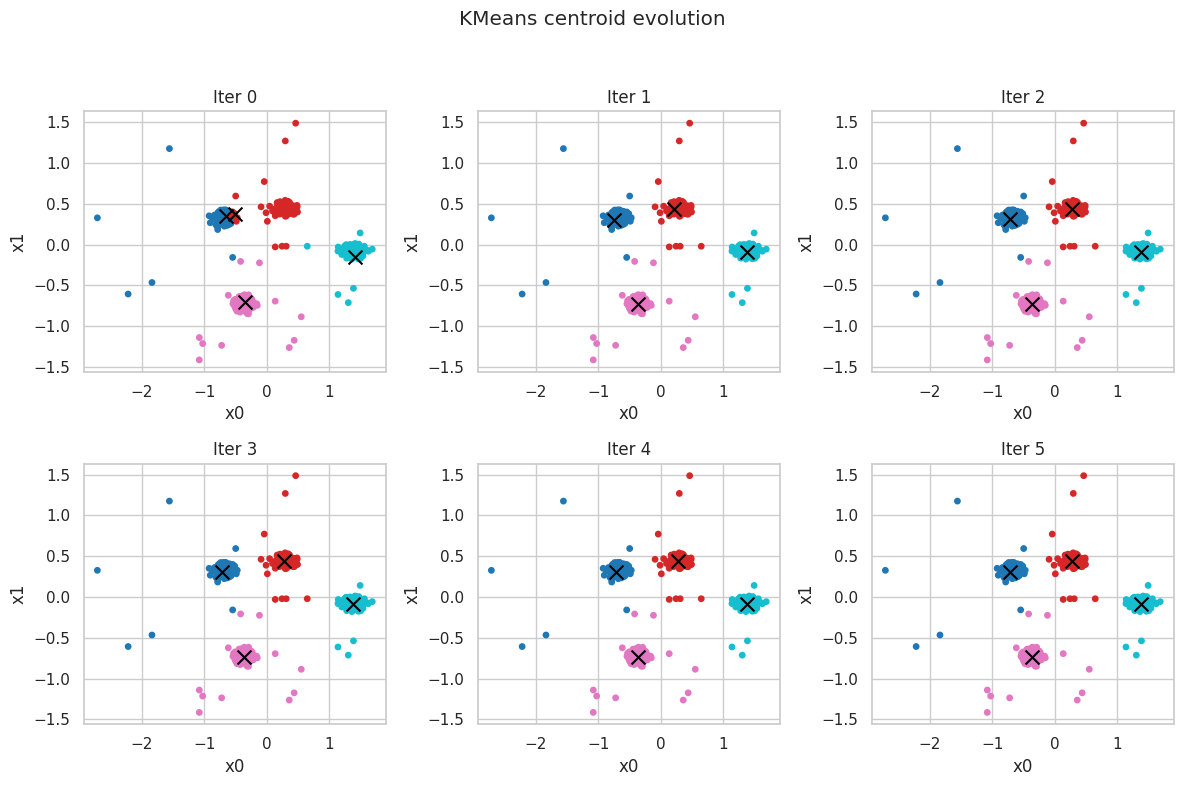

In [10]:
# Evolution: manual KMeans iterations to show centroid movement
def kmeans_iterations(X, k, n_iters=6, rng_seed=42):
    rng = np.random.RandomState(rng_seed)
    centers = X[rng.choice(X.shape[0], k, replace=False)].astype(float)
    frames = []
    for it in range(n_iters):
        dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
        labels = np.argmin(dists, axis=1)
        frames.append((centers.copy(), labels.copy()))
        new_centers = np.array([
            X[labels == j].mean(axis=0) if np.any(labels == j) else centers[j]
            for j in range(k)
        ])
        centers = new_centers
    dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
    labels = np.argmin(dists, axis=1)
    frames.append((centers.copy(), labels.copy()))
    return frames

frames = kmeans_iterations(Xtr, k=k, n_iters=5, rng_seed=42)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()
for i, (centers, labels) in enumerate(frames[:6]):
    ax = axes[i]
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=labels, cmap='tab10', s=15)
    ax.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', s=100)
    ax.set_title(f'Iter {i}')
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
plt.suptitle('KMeans centroid evolution')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

KMeans — Clear explanation with keywords

KMeans creates a fixed number of clusters by repeatedly assigning points to the nearest cluster center and moving the centers.

Key terms and short explanations:

- **k** — the number of clusters you ask the algorithm to find; you must choose this beforehand.
- **Centroid** — the center point of a cluster (average of its members); KMeans updates centroids each iteration.
- **Initialization** — the starting centroids can affect the final result; using multiple starts helps.
- **Outliers** — extreme points can pull centroids away; using robust preprocessing reduces this effect.

When to use KMeans: use it for compact, roughly round clusters and when you can estimate a reasonable value for k. Always scale features so distances are meaningful.

Conclusion / Observations

- KMeans recovered the spherical blob clusters well; **centroids** converged quickly and metrics (ARI/NMI) indicate good alignment with true labels on this dataset.
- KMeans assumes **compact, round clusters** and is sensitive to **k** and initialization; outliers can pull centroids away unless preprocessing is used.
- Robust preprocessing and multiple random starts (n_init) improve stability.

Next steps: run KMeans with different k to assess the elbow method, try multiple initializations or KMeans++ initialization, and compare with hierarchical clustering for small datasets.